In [1]:
import glob
import h5py

from gwpy.timeseries import TimeSeries

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
def find_max_times(path:str, n:int=1) -> np.ndarray:
    '''
    path, path to background.h5 file
    n, n highest maxima (e.g. n=2, top 2 highest detection statistic)

    return central times times for n highest detection statistics given background path
    '''
        
    background = h5py.File(path,'r')

    ds = background['parameters']['detection_statistic']
    central_time = background['parameters']['time']
    shift = background['parameters']['shift']

    try:
        ds = np.array(ds)
        ind = np.argpartition(ds,-n)[-n:] # indices of highest detection statistic
        ind = np.sort(ind)
        top_times = central_time[ind] # central times corresponding to highest detection statistic(s)
        top_shift = shift[ind] # shift L1 data by this amount

        return top_times, top_shift
    except ValueError:
        print('{} > {}, the length of the detection statistic array. Please choose a smaller integer'.format(n,len(ds)))

In [26]:
def load_background(path: str, times: np.ndarray, shifts: np.ndarray):
    '''
    Load in background.hdf5 data from data/test/background dir
    shifts: list of shifts for L1 data
    '''

    hdf5 = '*.hdf5'
    background = glob.glob(path + '/' + hdf5)    

    for b in background:
        start = b.index('-')
        end = b.index('-', start+1)
        start_time = b[start+1:end]

        start_dur = b.index('-', start+1)
        period = b.index('.')
        end_dur = b.index('.', period+1)
        duration = b[start_dur+1:end_dur]

        end_time = start_time + duration

        for counter, t in enumerate(times):
            if int(start_time) <= t <= int(end_time):
                H1 = TimeSeries.fetch_open_data('H1', start = int(t) - 2, end = int(t) + 2)
                H1 = H1.resample(2048)
                L1 = TimeSeries.fetch_open_data('L1', start = int(t) + int(shifts[counter][1]) - 2, 
                                                    end = int(t) + int(shifts[counter][1]) + 2)
                L1 = L1.resample(2048)
                
                ts_H1 = TimeSeries(H1, t0=t-2, sample_rate=2048)
                qgrams_H1 = ts_H1.q_transform() 
                plot_H1 = qgrams_H1.plot()
                plt.gca().set_title('H1 Omegascan')
                plot_H1.show()
                plot_H1.savefig('omega_scan_H1_{time}_{number}.png'.format(time=t, number=counter))              

                ts_L1 = TimeSeries(L1, t0=t-2, sample_rate=2048)
                qgrams_L1 = ts_L1.q_transform() 
                plot_L1 = qgrams_L1.plot()
                plt.gca().set_title('L1 Omegascan')
                plot_L1.show()
                plot_L1.savefig('omega_scan_L1_{time}_{number}.png'.format(time=t, number=counter))
            else:
                continue

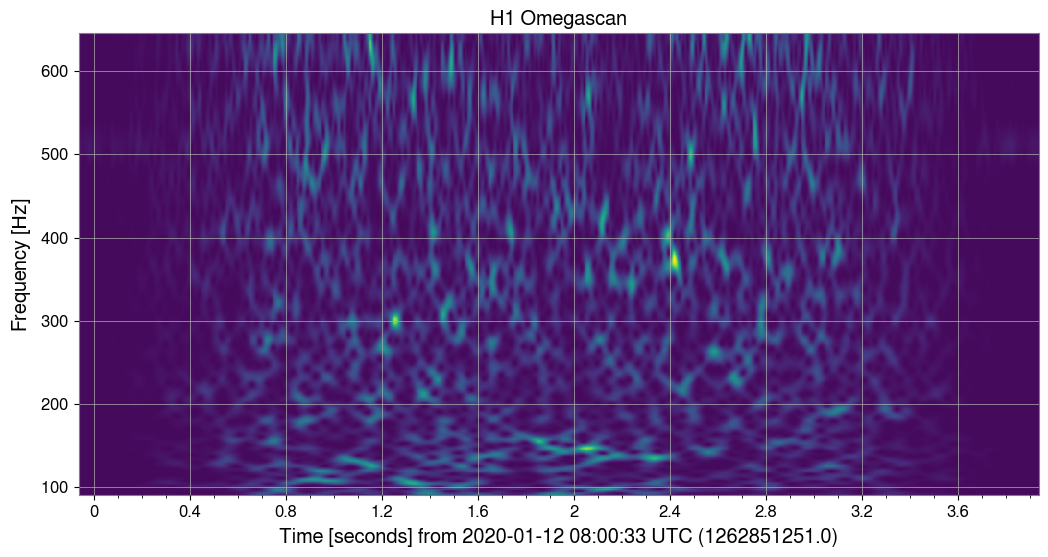

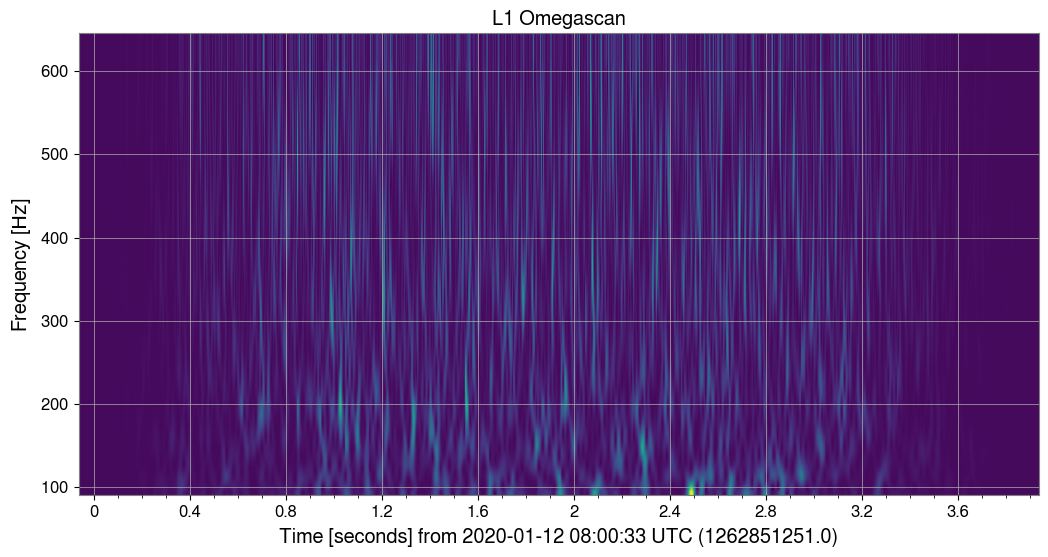

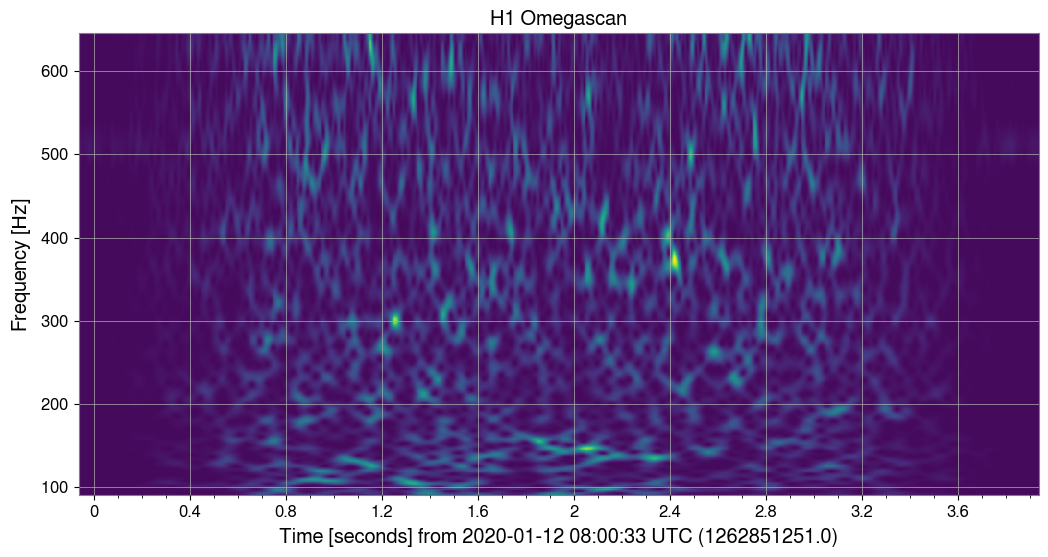

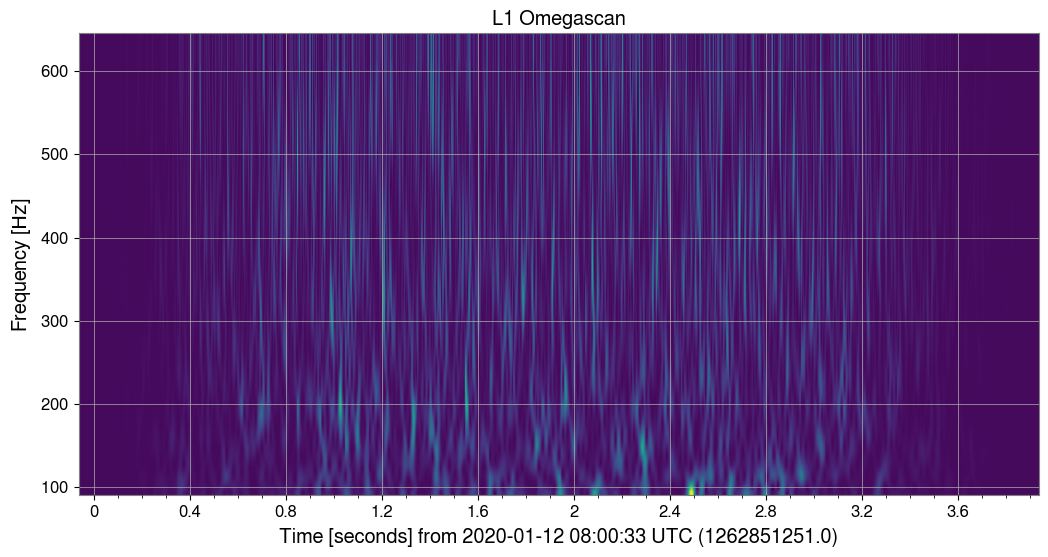

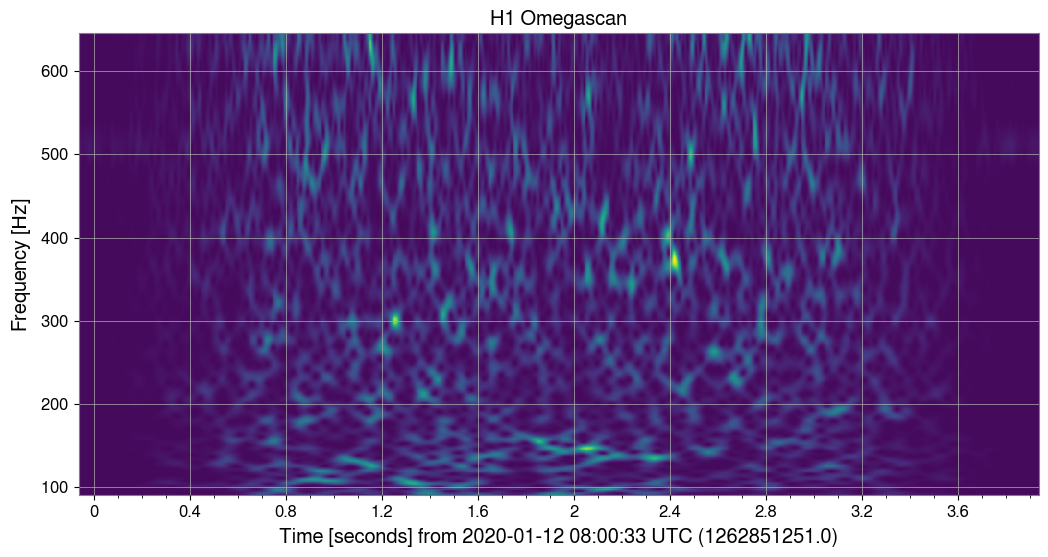

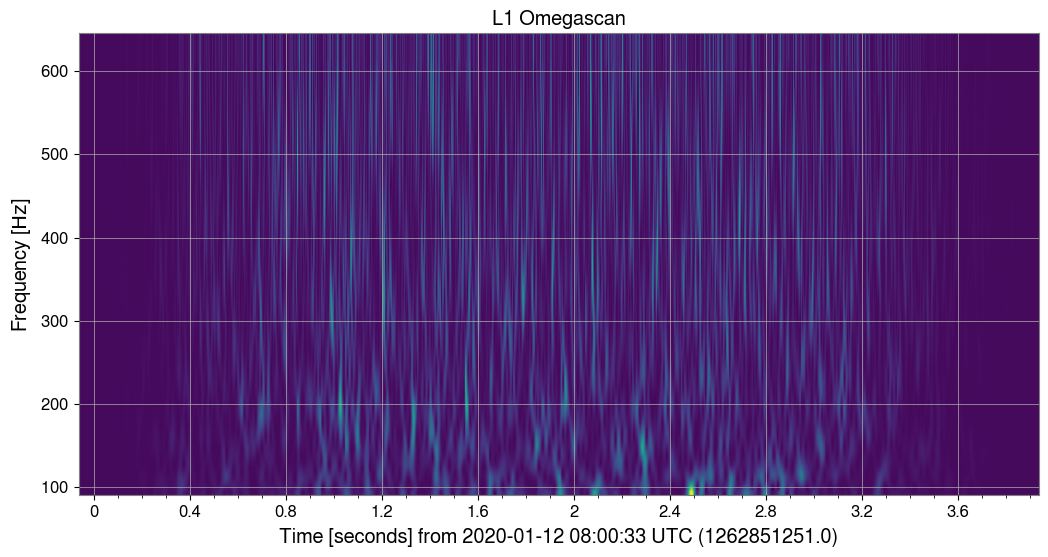

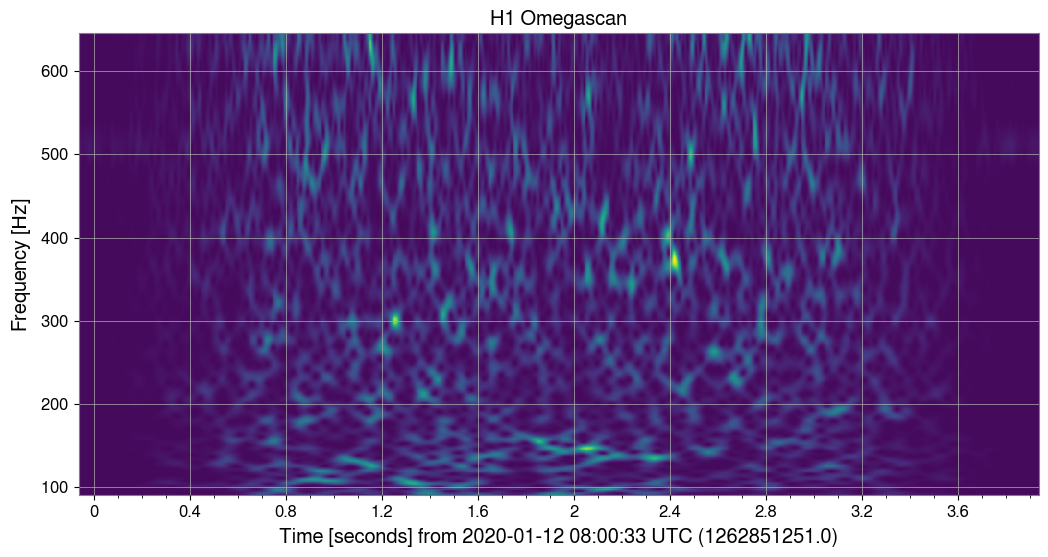

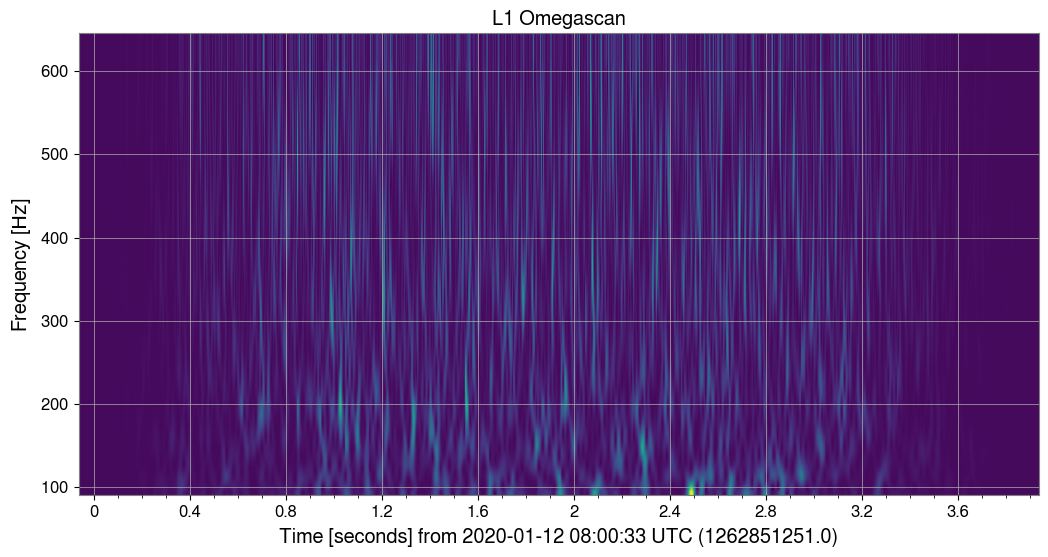

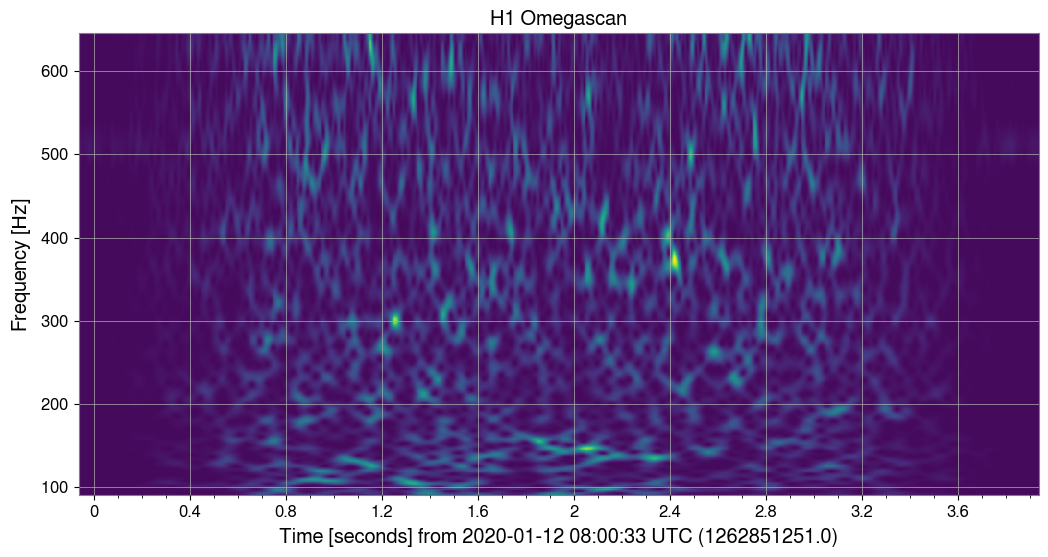

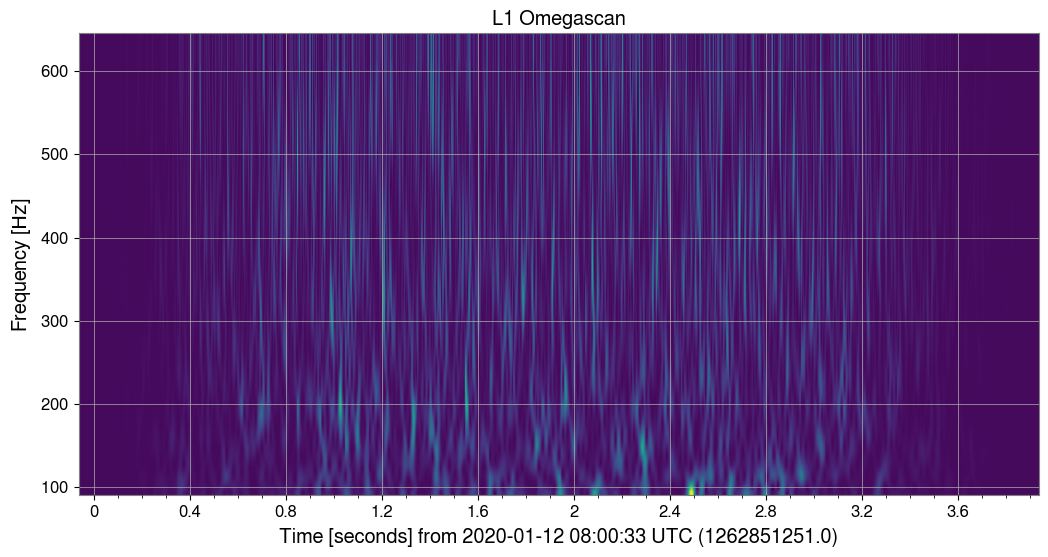

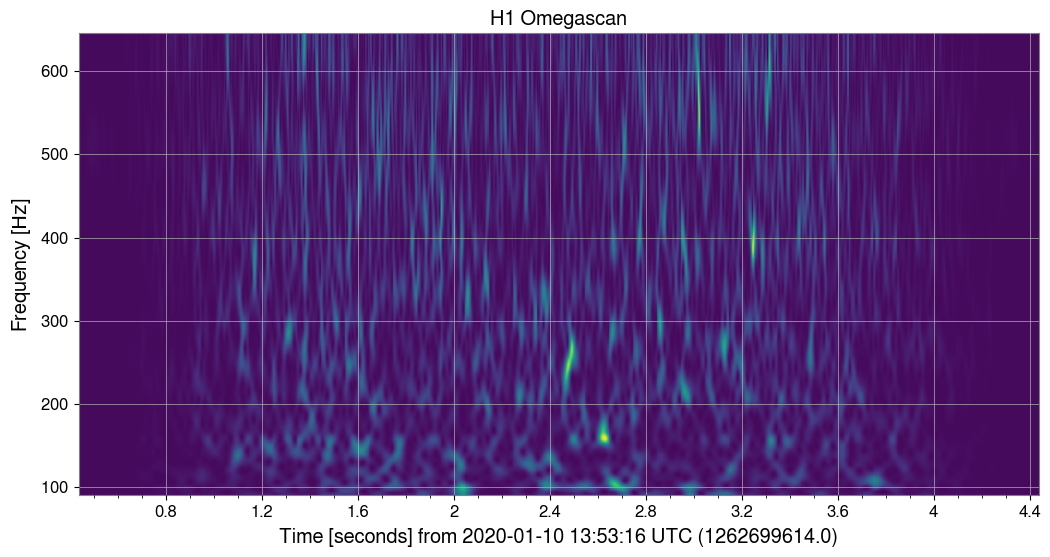

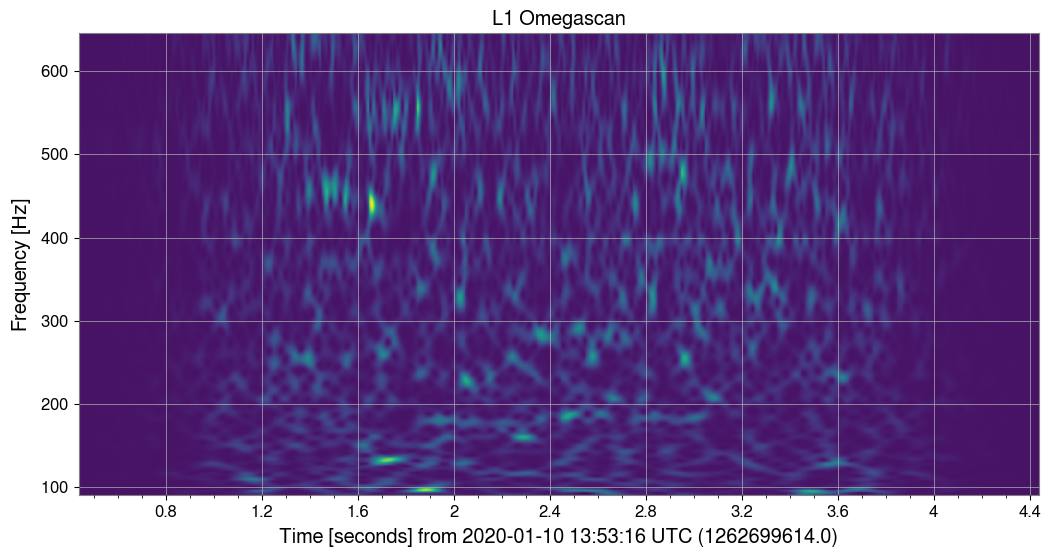

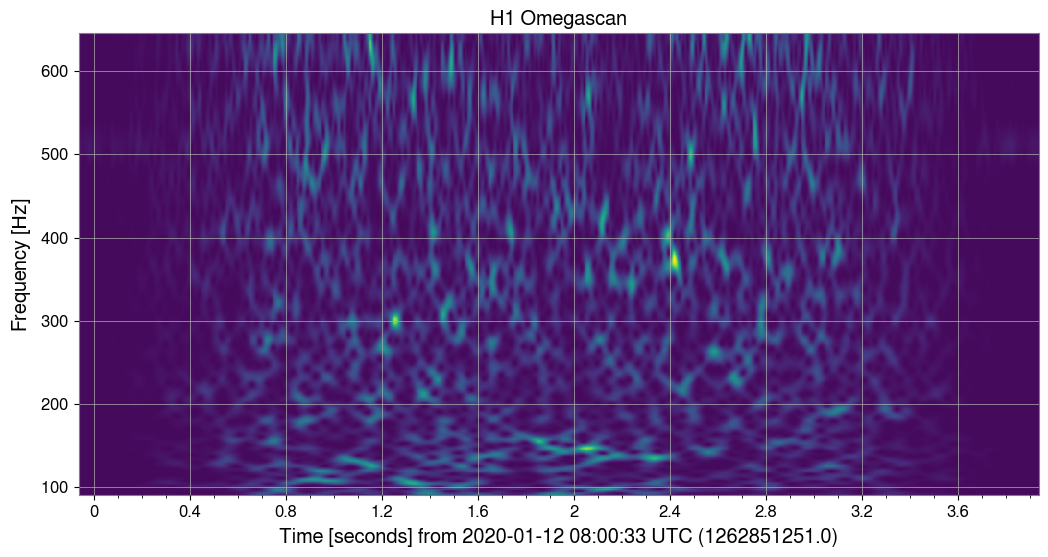

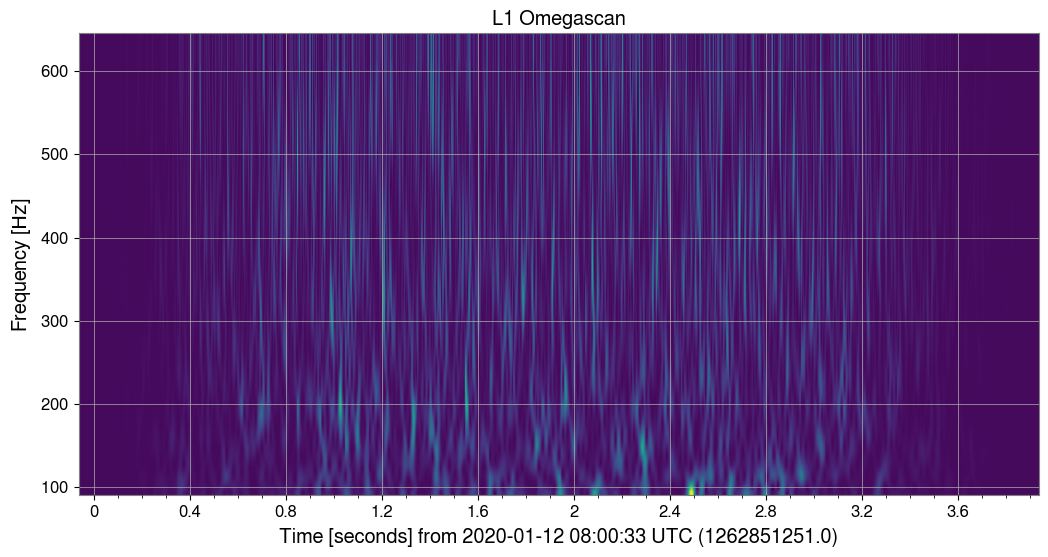

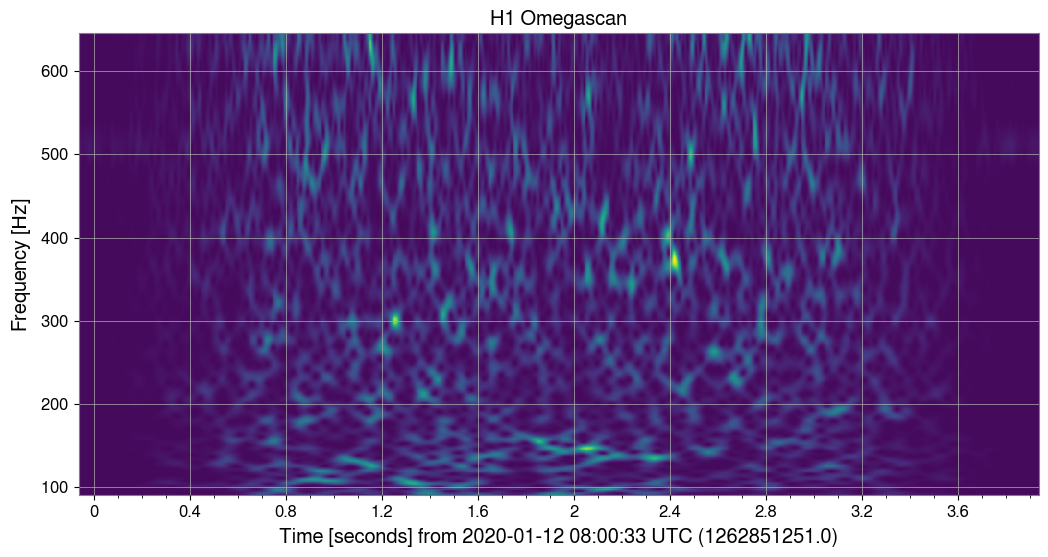

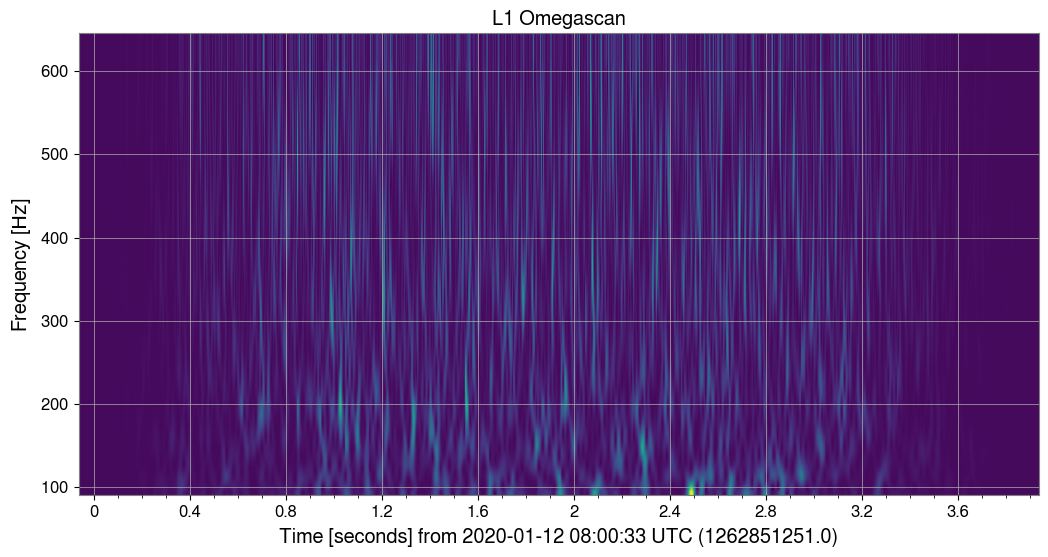

In [27]:
times, shifts = find_max_times('/home/ricco.venterea/results/my-first-run/infer/background.h5', n=2)
load_background('/home/ricco.venterea/data/test/background', times=times, shifts=shifts)